In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import pickle
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data loader

Since a CNN needs a image shape as input let's reshape our flatten images to real image

In [2]:
band_n = 4
channel_n = 4
# Define sampling frequency
sampling_rate = 125
window_size_in_seconds = 24
time_window_size = 128 # 

data_dir = 'Data'
# data_f = f'Data/Copy of eeg_focus_6sessions_cut_S1padding_{window_size_in_seconds}s.processed.csv'

def load_data(f, discrete_output=True, use_all=False, sample_ranges=[]):
    df_new = pd.read_csv(open(f))
    if not use_all:
        for sample_range in sample_ranges:
            # sample_range: [start_idx, end_idx, sample_num, score]
            if len(sample_range) >= 4:
                df_new['y'] = np.NaN
                random_idx = random.sample(population = range(sample_range[0]*sampling_rate, sample_range[1]*sampling_rate), k = sample_range[2]) 
                df_new.loc[random_idx, 'y'] = sample_range[3]
        
        if not discrete_output:
            _df_data = df_new[~df_new['y'].isnull()]
        else:
            _df_data = df_new[(~df_new['y'].isnull()) & ((df_new['y'] < 0.01) | (df_new['y'] > 0.99))]
            _df_data = _df_data.astype({'y': int})
    elif discrete_output:
        _df_data = df_new[((df_new['y'] < 0.01) | (df_new['y'] > 0.99) | (df_new['y'].isnull()))]
        _df_data = _df_data.fillna(-1)
        _df_data = _df_data.astype({'y': int})
    else:
        _df_data = df_new
        
    print(f"loaded file: {f}, df_data shape: {_df_data.shape}, df_new shape: {df_new.shape}")
    return _df_data

def create_datasets(
                    data_files,
                    data_ranges,
                    use_standard_scaler=False, 
                    discrete_output=True, 
                    max_samples=10000,
                   ):
    df_list = []
    for f, sample_ranges in zip(data_files, data_ranges):
        _df_data = load_data(f, discrete_output=discrete_output, sample_ranges=sample_ranges, use_all=False)
        df_list.append(_df_data)
    df_data = pd.concat(df_list)
    if len(df_data) > max_samples:
        df_data = df_data[:max_samples]
    
    X = np.array(df_data.drop(columns=['y']))    
    # Scale data [0, 255]
    if not use_standard_scaler:
        X = 255*(X - X.min())/(X.max() - X.min())
    else:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    y = np.array(df_data['y'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    # y_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
    X_val, y_val = X_test, y_test
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}, X_val shape: {X_val.shape}, y_val shape: {y_val.shape},")
    return X_train, X_test, y_train, y_test, X_val, y_val

def create_torch_data_loader(X_train, X_test, y_train, y_test, X_val, y_val, batch_size = 1024, 
                             band_n = 4, channel_n = 4, time_window_size=0, image_format=True, shuffle=False):
    # convert datasets to torch datasets
    
    torch_X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    torch_y_train = torch.from_numpy(y_train)
    
    # create feature and targets tensor for test set.
    torch_X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    torch_y_test = torch.from_numpy(y_test)
    torch_X_val = torch.from_numpy(X_val).type(torch.FloatTensor)
    torch_y_val = torch.from_numpy(y_val)
    
    # Reshape
    if image_format:
        if time_window_size > 0:
            torch_X_train = torch_X_train.view(-1, channel_n, time_window_size, band_n).float()
            torch_X_test = torch_X_test.view(-1, channel_n, time_window_size, band_n).float()
            torch_X_val = torch_X_val.view(-1, channel_n, time_window_size, band_n).float()
        else:
            torch_X_train = torch_X_train.view(-1, 1, 1, band_n).float()
            torch_X_test = torch_X_test.view(-1, 1, 1, band_n).float()
            torch_X_val = torch_X_val.view(-1, 1, 1, band_n).float()
        
    
    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(torch_X_train, torch_y_train)
    test = torch.utils.data.TensorDataset(torch_X_test, torch_y_test)
    val = torch.utils.data.TensorDataset(torch_X_val, torch_y_val)
    
    
    # data loader
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = shuffle)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = shuffle)
    val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = shuffle)
    return train_loader, test_loader, val_loader

## Baseline model

In [3]:
# build custom module for logistic regression
class MyLogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super(MyLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    # make predictions
    def forward(self, x):
        out = self.linear(x)
        y_pred = torch.nn.functional.softmax(out, dim=1)
        return y_pred


In [4]:
# Predict
def baseline_predict_dataset(loaded_model, data_f):
    df_new = pd.read_csv(open(data_f))
    scaler = StandardScaler()
    y_pred = loaded_model.predict_proba(scaler.fit_transform(np.array(df_new.drop(columns=['y']))))[:,1]
    
    # Scale between 0 and 100
    xmax = 100
    min_val, max_val = np.min(y_pred), np.max(y_pred)
    scaled_arr = xmax * (y_pred - min_val) / (max_val - min_val)\
    
    time = np.arange(len(df_new)) / sampling_rate
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(time, scaled_arr, label='Focus Level')
    plt.title(f'{data_f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Focus Score')
    plt.grid(True)
    plt.show()



In [6]:
ex_files = [
    'Copy of eeg_focus_6sessions_cut_S2.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S3.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S4.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S5.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S7.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S8.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S9.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S10.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S13.b4.padding_0s.processed.csv',
    'Copy of eeg_focus_6sessions_cut_S6.b4.padding_0s.processed.csv'
]
X_train, X_test, y_train, y_test, X_val, y_val = create_datasets(0, use_standard_scaler=True, discrete_output=True, ex_files=ex_files)

TypeError: create_datasets() got an unexpected keyword argument 'ex_files'

In [7]:
X_train[0], y_train[:10]

NameError: name 'X_train' is not defined

In [8]:
# Train a linear regression model
model = LogisticRegression(random_state=42, multi_class='auto')

model.fit(X_train, y_train)
# save model
pickle.dump(model, open('model.pkl', 'wb'))
# Evaluate the model
y_pred = model.predict_proba(X_test)[:,1]
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print("Mean Squared Error", mse)
# y_pred

NameError: name 'X_train' is not defined

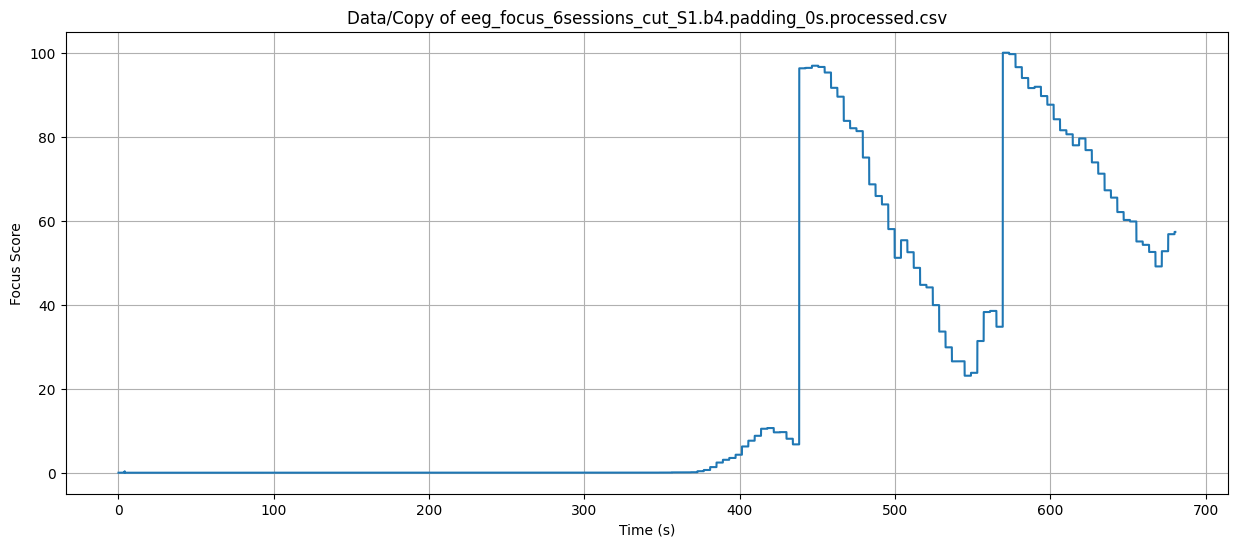

In [163]:
data_f = 'Data/Copy of eeg_focus_6sessions_cut_S1.b4.padding_0s.processed.csv'
baseline_predict_dataset(model, data_f)

## CNN model

In [5]:
def fit(model, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('running on device %s'%device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters()) #, weight_decay=0.00001)
    # error = nn.CrossEntropyLoss()
    l2_error = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            # loss = l2_error(output[:, 1], var_y_batch.float()) # softmax
            loss = l2_error(output[:, 0], var_y_batch.float()) # sigmoid
            # loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tloss: {}'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data))

def evaluate(model, test_loader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('running on device %s'%device)
    model.to(device)
    
    loss_func = nn.MSELoss() # Mean Squared Error
    # loss_func = nn.CrossEntropyLoss()
    correct = 0 
    batch_c = 0
    loss = 0.0
    predict_score = []
    true_score = []
    model.eval()
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        # _loss = loss_func(output[:, 1], test_labels)
        _loss = loss_func(output[:, 0], test_labels) # sigmoid
        loss += _loss.data
        # loss += loss_func(output, test_labels)
        batch_c += 1
        # predict_score += output[:, 1].tolist()
        predict_score += output[:, 0].tolist() # sigmoid
        true_score += test_labels.tolist()
    print("L2 loss:{}".format(float(loss)/batch_c))
    df = pd.DataFrame({'predict_scores': predict_score, 'true_score': true_score})
    # print(df[df['true_score']>0.99])
    return df


def evaluate_dataset(model, data_f, image_shape=True, time_window_size=0, band_n=4, batch_size = 1024,
                     discrete_output=True, use_standard_scaler=False, device=None):
    
    df_data = load_data(data_f, discrete_output=discrete_output, use_all=True)
    X = np.array(df_data.drop(columns=['y']))
    if not use_standard_scaler:
        X = 255*(X - X.min())/(X.max() - X.min())
    else:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    y = np.array(df_data['y'])
    
    torch_X = torch.from_numpy(X).type(torch.FloatTensor)
    torch_y = torch.from_numpy(y)
    # Reshape
    if image_shape and time_window_size > 0:
        torch_X = torch_X.view(-1, channel_n, time_window_size, band_n).float()

    # Pytorch train and test sets
    data = torch.utils.data.TensorDataset(torch_X, torch_y)

    # data loader
    data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = False)
    
    df = evaluate(model, data_loader, device=device)
    
    y_pred = df['predict_scores']
    # Scale between 0 and 100
    xmax = 100
    min_val, max_val = np.min(y_pred), np.max(y_pred)
    scaled_arr = xmax * (y_pred - min_val) / (max_val - min_val)\
    
    time = np.arange(len(df)) / sampling_rate
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(time, scaled_arr, label='Focus Level')
    plt.title(f'{data_f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Focus Score')
    plt.grid(True)
    plt.show()
    
    

In [6]:
y_train[:10]

NameError: name 'y_train' is not defined

In [7]:
# train custome model
# instantiate the model

n_inputs = band_n
n_outputs = 2
log_regr = MyLogisticRegression(n_inputs, n_outputs)
train_loader, test_loader, val_loader = create_torch_data_loader(X_train, X_test, y_train, y_test, X_val, y_val, 
                                                                 batch_size = 1024, band_n = 4, time_window_size=0, 
                                                                image_format=False)

NameError: name 'X_train' is not defined

Epoch : 0 [0/7225 (0%)]	loss: 0.27297699451446533
Epoch : 1 [0/7225 (0%)]	loss: 0.26103124022483826
Epoch : 2 [0/7225 (0%)]	loss: 0.24941830337047577
Epoch : 3 [0/7225 (0%)]	loss: 0.2381911426782608
Epoch : 4 [0/7225 (0%)]	loss: 0.22740449011325836
Epoch : 5 [0/7225 (0%)]	loss: 0.21710242331027985
Epoch : 6 [0/7225 (0%)]	loss: 0.20731718838214874
Epoch : 7 [0/7225 (0%)]	loss: 0.19806939363479614
Epoch : 8 [0/7225 (0%)]	loss: 0.1893690824508667
Epoch : 9 [0/7225 (0%)]	loss: 0.18121647834777832
loaded file: Data/Copy of eeg_focus_6sessions_cut_S1.b4.padding_0s.processed.csv, df_data shape: (70289, 5), df_new shape: (85057, 5)
L2 loss:1.8244434301403984


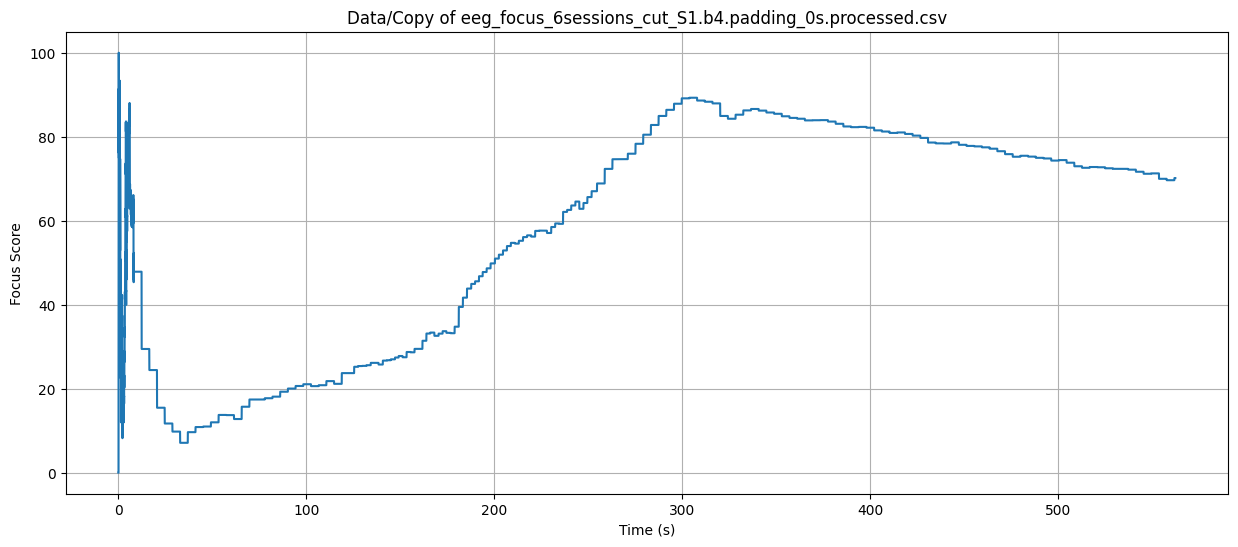

In [168]:


fit(log_regr, train_loader, val_loader, epochs=10)
data_f = 'Data/Copy of eeg_focus_6sessions_cut_S1.b4.padding_0s.processed.csv'
evaluate_dataset(log_regr, data_f, image_shape=False, discrete_output=True, use_standard_scaler=True)

In [12]:
# Load datasets
ex_files = []
window_size_in_seconds = 24
time_window_size = 128
# ex_subjects = [2, 3, 4, 5, 6, 7, 9, 10, 13]
# ex_subjects = [13, 6, 2, 5]

# 9, 6, 13, 2, 7
# ex_subjects = [1, 8, 2, 7, 3, 4, 5, 6, 9, 10,]
ex_subjects = [8, 7, 2, 3, 4, 5, 6, 9, 10, 13]

# for s in ex_subjects:
#     ex_files.append(f'Copy of eeg_focus_6sessions_cut_S{s}.b4.padding_{window_size_in_seconds}s.processed.csv')

# processed_data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) 
#                         if f.endswith(f'padding_{window_size_in_seconds}s.processed.csv') and f not in ex_files]

processed_data_files = [
    # 'Data/Copy of eeg_focus_6sessions_cut_S1.b4.padding_24s.processed.csv',
    # 'Data/Copy of eeg_focus_6sessions_cut_S6.b4.padding_24s.processed.csv',
    # 'Data/Copy of eeg_focus_6sessions_cut_S13.b4.padding_24s.processed.csv',
    # 'Data/Copy of eeg_focus_6sessions_cut_S8.b4.padding_24s.processed.csv',
    # 'Data/Copy of eeg_focus_6sessions_cut_S9.b4.padding_24s.processed.csv',
    '/data1/Test/Copy of eeg_focus_6sessions_cut_S13feature_n4096.window_size_8s.processed.csv',
    '/data1/Test/Copy of eeg_focus_6sessions_cut_S1feature_n4096.window_size_8s.processed.csv',
    '/data1/Test/Copy of eeg_focus_6sessions_cut_S3feature_n4096.window_size_8s.processed.csv',
    '/data1/Test/Copy of eeg_focus_6sessions_cut_S8feature_n4096.window_size_8s.processed.csv',
    
    
]
data_ranges = [[],
               # [[0, 100, 1024, 0.0]], 
               # [[500, 650, 1024, 1.0]],
               # [[0, 100, 1024, 0.0], [360, 620, 1024, 1.0]],
               # [[360, 550, 1024, 1.0]],
               [],
               [],
               []
              ]
X_train, X_test, y_train, y_test, X_val, y_val = create_datasets(data_files=processed_data_files, 
                                                                 data_ranges=data_ranges,
                                                                 use_standard_scaler=True, 
                                                                 discrete_output=False, 
                                                                 max_samples=1000000)


loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S13feature_n4096.window_size_8s.processed.csv, df_data shape: (5650, 4097), df_new shape: (83746, 4097)
loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S1feature_n4096.window_size_8s.processed.csv, df_data shape: (5665, 4097), df_new shape: (85057, 4097)
loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S3feature_n4096.window_size_8s.processed.csv, df_data shape: (5616, 4097), df_new shape: (77889, 4097)
loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S8feature_n4096.window_size_8s.processed.csv, df_data shape: (5662, 4097), df_new shape: (78638, 4097)
X_train shape: (19204, 4096), y_train shape: (19204,), X_test shape: (3389, 4096), y_test shape: (3389,), X_val shape: (3389, 4096), y_val shape: (3389,),


In [13]:
train_loader, test_loader, val_loader = create_torch_data_loader(X_train, X_test, y_train, y_test, X_val, y_val, 
                                                                 batch_size = 1024, band_n = 32, channel_n = 4, 
                                                                 time_window_size=32,
                                                                 shuffle=True)

# y_train[y_train > 0.8].shape
y_train[y_train < 0.1].shape
# f = 'Data/Copy of eeg_focus_6sessions_cut_S1.b4.padding_2s.processed.csv'
# df_data = load_data(f, discrete_output=False)
# df_data.shape
# df_data[df_data['y'] > .5]
# X_train.shape


(6018,)

In [ ]:
f = '/data1/Test/Copy of eeg_focus_6sessions_cut_S13feature_n4096.window_size_8s.processed.csv'
df = pd.read_csv(f)
# _df_data = load_data(f, discrete_output=False, sample_ranges=[], use_all=True)
df.shape

In [42]:
_df_data['y'].value_counts()
df['y'].value_counts()

y
1.00    20610
0.00       63
0.75       63
0.25       62
Name: count, dtype: int64

## Explanation

To better understand convolutional neural network I recommend the great section on it here : http://cs231n.github.io/convolutional-networks/

**Convolutional operation** : First let's clarify briefly how we can perform the convolutional operation on an image. For that we need to define a **kernel** which is a small matrix of size 5 \* 5 for example. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

**Pooling** : the convolutional operation give an output of the same size of the input image. To reduce the size of the image and thus reduce the number of paramers in the model we perform a Pooling operation. The pooling operation need a window size.. By sliding the window along the image, we compute the mean or the max of the portion of the image inside the window in case of MeanPooling or MaxPooling.

**Stride** is the number of pixels to pass at a time when sliding the convolutional kernel.  

**Padding** to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image. 


**To remember** : What makes a CNN so interesting for images is that it is invariant by translation and for each convolutional layer we only need to store the kernels. Thus we can stack a lot of layers to learn deep features without having too much parameters that would make a model untrainnable. 

In [ ]:
class ConvNet(nn.Module): 
    def __init__(self, dropout=0.05):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
           #nn.ZeroPad2d((15,15,0,0)),
           nn.Conv2d(in_channels = 4, out_channels = 80, kernel_size = (3, 1), stride = (1, 1), padding = 0),
           nn.LeakyReLU(),
           nn.Dropout(p=dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 80, out_channels = 160, kernel_size = (3, 1), stride = (2, 1), padding = 0),
            nn.BatchNorm2d(160, affine=False),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = (3,1), stride = (3,1))
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels = 320, kernel_size = (5,1), stride = (1,1)),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout))
        self.pool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,1), stride=(3,1)))
        self.layer4 = nn.Sequential(
            #nn.ZeroPad2d((15,15,0,0)),
            nn.Conv2d(in_channels=320, out_channels = 640, kernel_size = (3,1), stride = (1,1)),
            nn.BatchNorm2d(640, affine=False),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout))
        self.pool3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,1), stride=(3,1)))
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 640, out_channels = 1280, kernel_size = (3,1), stride=(7,1)),
            nn.BatchNorm2d(1280, affine=False),
            nn.LeakyReLU())
        self.pool4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,1), stride=(3,1)))
        self.linear1 = nn.Sequential(
            nn.Linear(2560, 1),
            # nn.Softmax(dim=1)
        )
        
            
    def forward(self, x):
        # print("input: ", x[0].shape)
        out = self.layer1(x)
        # print("layer1: ",out[0].shape)
        out = self.layer2(out)
        # print("layer2: ",out[0].shape)
        out= self.layer3(out)
        # print("layer3: ",out[0].shape)
        out = self.pool2(out)
        # print("pool2: ",out[0].shape)
        out = self.layer4(out)
        # print("layer4: ",out[0].shape)
        out = self.pool3(out)
        out = torch.flatten(out, start_dim=1)
        # print("out: ", out.shape)
        out = self.linear1(out)
        # print("out: ", out.shape)
        out = torch.sigmoid(out)
        return out


# cnn = ConvNet()
# print(cnn)

# it = iter(train_loader)
# X_batch, y_batch = next(it)
# print(cnn.forward(X_batch).shape)

In [8]:
class STFTConvNet(nn.Module): 
    def __init__(self, dropout=0.05):
        super(STFTConvNet, self).__init__()
        self.layer1 = nn.Sequential(
           #nn.ZeroPad2d((15,15,0,0)),
           nn.Conv2d(in_channels = 4, out_channels = 80, kernel_size = (3, 3), stride = (1, 1), padding = 0),
           nn.LeakyReLU(),
           nn.Dropout(p=dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 80, out_channels = 160, kernel_size = (3, 3), stride = (1, 1), padding = 0),
            nn.BatchNorm2d(160, affine=False),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = (3,3), stride = (1,1))
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels = 320, kernel_size = (3,3), stride = (1,1)),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout))
        self.pool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1)))
        self.layer4 = nn.Sequential(
            #nn.ZeroPad2d((15,15,0,0)),
            nn.Conv2d(in_channels=320, out_channels = 640, kernel_size = (3,3), stride = (3,3)),
            nn.BatchNorm2d(640, affine=False),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout))
        self.pool3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(3,3)))
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 640, out_channels = 1280, kernel_size = (3,3), stride=(1,1)),
            nn.BatchNorm2d(1280, affine=False),
            nn.LeakyReLU())
        self.pool4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1)))
        self.linear1 = nn.Sequential(
            nn.Linear(154880, 1),
            # nn.Softmax(dim=1)
        )
        
            
    def forward(self, x):
        # print("input: ", x[0].shape)
        out = self.layer1(x)
        # print("layer1: ",out[0].shape)
        out = self.layer2(out)
        # print("layer2: ",out[0].shape)
        out= self.layer3(out)
        # print("layer3: ",out[0].shape)
        out = self.pool2(out)
        # print("pool2: ",out[0].shape)
        out = self.layer4(out)
        # print("layer4: ",out[0].shape)
        out = self.pool3(out)
        out = torch.flatten(out, start_dim=1)
        # print("out: ", out.shape)
        out = self.linear1(out)
        # print("out: ", out.shape)
        out = torch.sigmoid(out)
        return out

stft_cnn = STFTConvNet()
# print(stft_cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(stft_cnn.forward(X_batch).shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x2560 and 154880x1)

## ResNet

In [14]:
class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, stride=1, identity_downsample=None, expansion=4):
        super(Block, self).__init__()
        self.expansion = expansion
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    
    def forward(self, x):
        identity = x.clone()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.expansion=4
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # 
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []
        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels*self.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, self.expansion*intermediate_channels, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*intermediate_channels)
            )
        layers.append(block(self.in_channels, intermediate_channels, stride=stride, identity_downsample=identity_downsample))
        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * self.expansion
        
        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

def ResNet50(img_channel=4, num_classes=1):
    return ResNet(Block, [3, 4, 6, 3], img_channel, num_classes)

def ResNet101(img_channel=4, num_classes=1):
    return ResNet(Block, [3, 4, 23, 3], img_channel, num_classes)

def ResNet152(img_channel=4, num_classes=1):
    return ResNet(Block, [3, 8, 36, 3], img_channel, num_classes)

model = ResNet101()
x = torch.randn(2, 4, 32, 32)
model.forward(x)


tensor([[0.2975],
        [0.1954]], grad_fn=<SigmoidBackward0>)

In [15]:
fit(model, train_loader, val_loader, epochs=100)


running on device cuda
Epoch : 0 [0/19204 (0%)]	loss: 0.24069048464298248
Epoch : 0 [10240/19204 (53%)]	loss: 0.10594551265239716
Epoch : 1 [0/19204 (0%)]	loss: 0.04930051416158676
Epoch : 1 [10240/19204 (53%)]	loss: 0.04667863994836807
Epoch : 2 [0/19204 (0%)]	loss: 0.033270519226789474
Epoch : 2 [10240/19204 (53%)]	loss: 0.03540816530585289
Epoch : 3 [0/19204 (0%)]	loss: 0.022670675069093704
Epoch : 3 [10240/19204 (53%)]	loss: 0.016671597957611084
Epoch : 4 [0/19204 (0%)]	loss: 0.012578928843140602
Epoch : 4 [10240/19204 (53%)]	loss: 0.0125742731615901
Epoch : 5 [0/19204 (0%)]	loss: 0.014711673371493816
Epoch : 5 [10240/19204 (53%)]	loss: 0.01865486614406109
Epoch : 6 [0/19204 (0%)]	loss: 0.009198971092700958
Epoch : 6 [10240/19204 (53%)]	loss: 0.007179529406130314
Epoch : 7 [0/19204 (0%)]	loss: 0.007280905731022358
Epoch : 7 [10240/19204 (53%)]	loss: 0.003889018902555108
Epoch : 8 [0/19204 (0%)]	loss: 0.003805086947977543
Epoch : 8 [10240/19204 (53%)]	loss: 0.0038357593584805727
Epo

In [17]:
val_rs = evaluate(model, test_loader, device=torch.device('cuda'))
# val_rs1 = evaluate(cnn, train_loader)
import time
# torch.save(cnn.state_dict(), f'eeg_cnn_{int(time.time())}.pt')

running on device cuda
L2 loss:0.0004131632641823528


loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S13feature_n4096.window_size_8s.processed.csv, df_data shape: (83746, 4097), df_new shape: (83746, 4097)
running on device cuda
L2 loss:nan


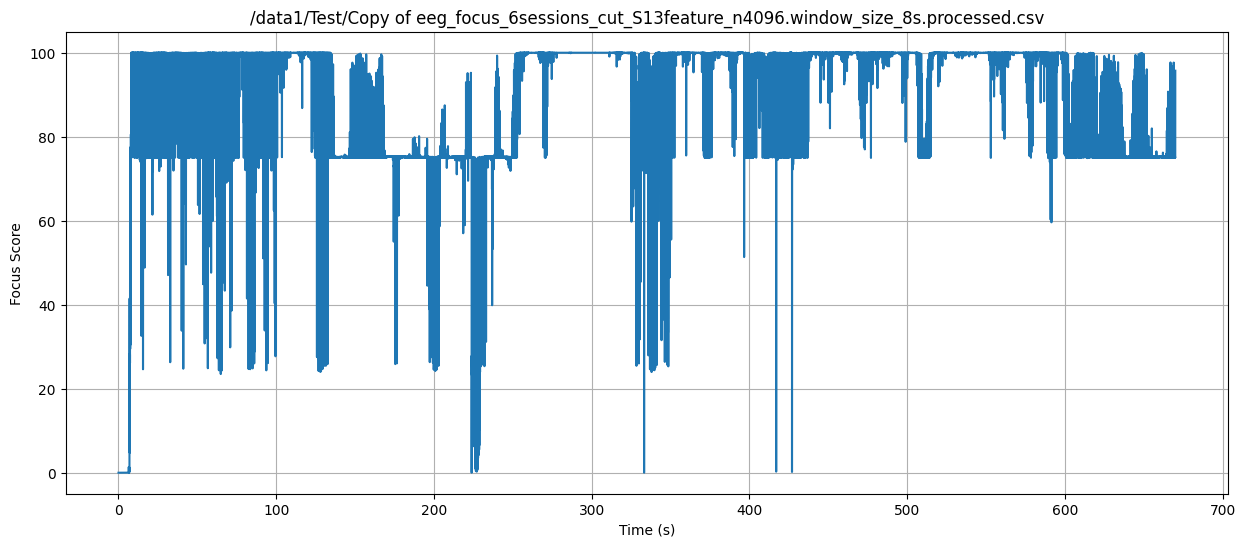

loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S1feature_n4096.window_size_8s.processed.csv, df_data shape: (85057, 4097), df_new shape: (85057, 4097)
running on device cuda
L2 loss:nan


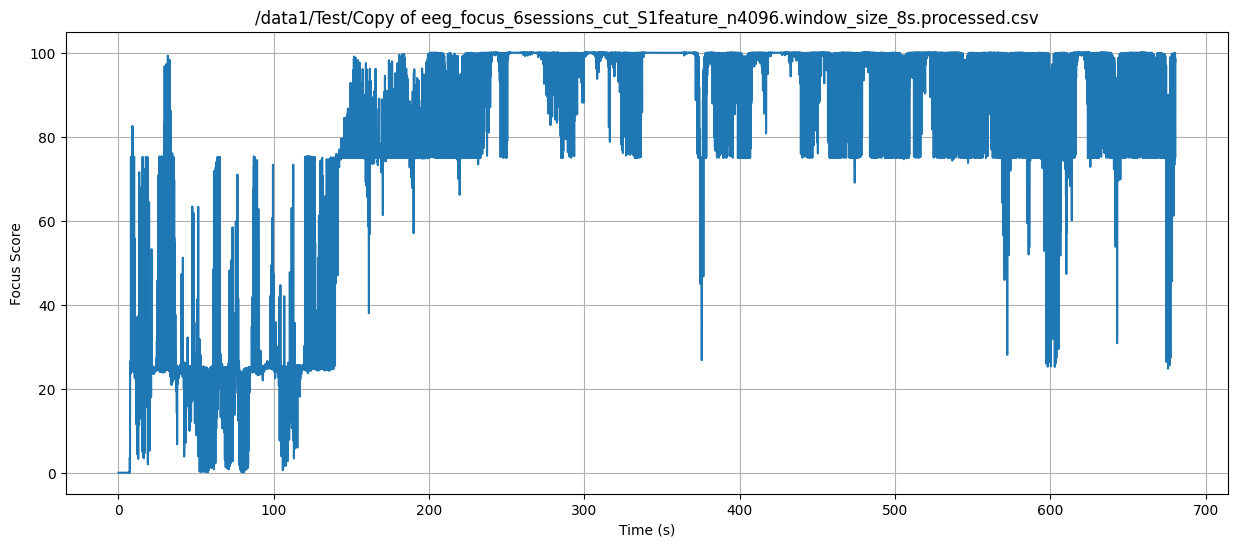

loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S3feature_n4096.window_size_8s.processed.csv, df_data shape: (77889, 4097), df_new shape: (77889, 4097)
running on device cuda
L2 loss:nan


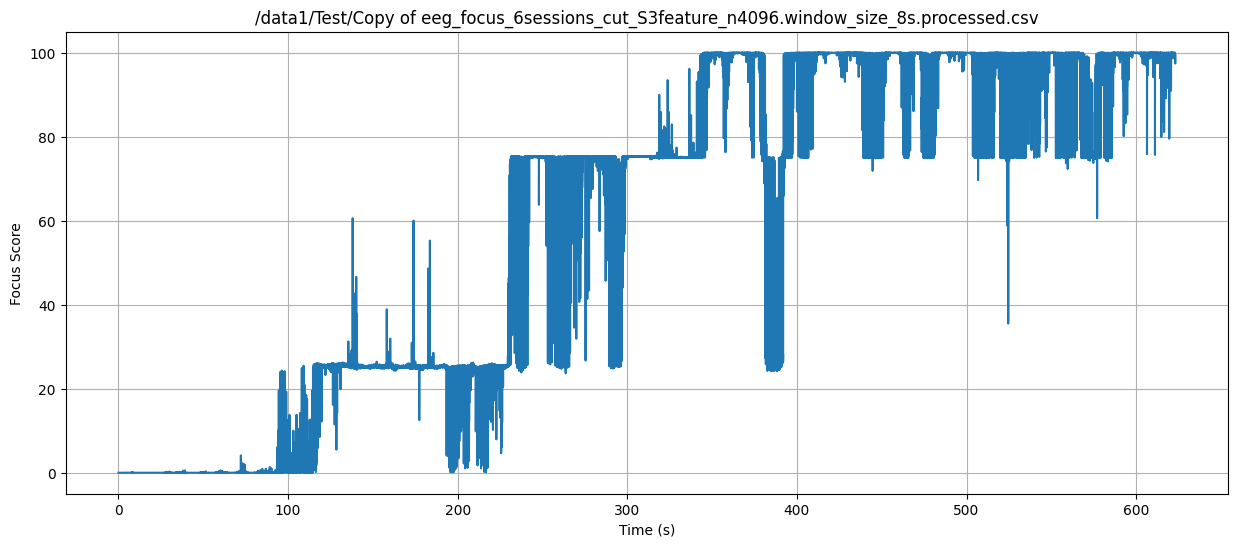

loaded file: /data1/Test/Copy of eeg_focus_6sessions_cut_S8feature_n4096.window_size_8s.processed.csv, df_data shape: (78638, 4097), df_new shape: (78638, 4097)
running on device cuda
L2 loss:nan


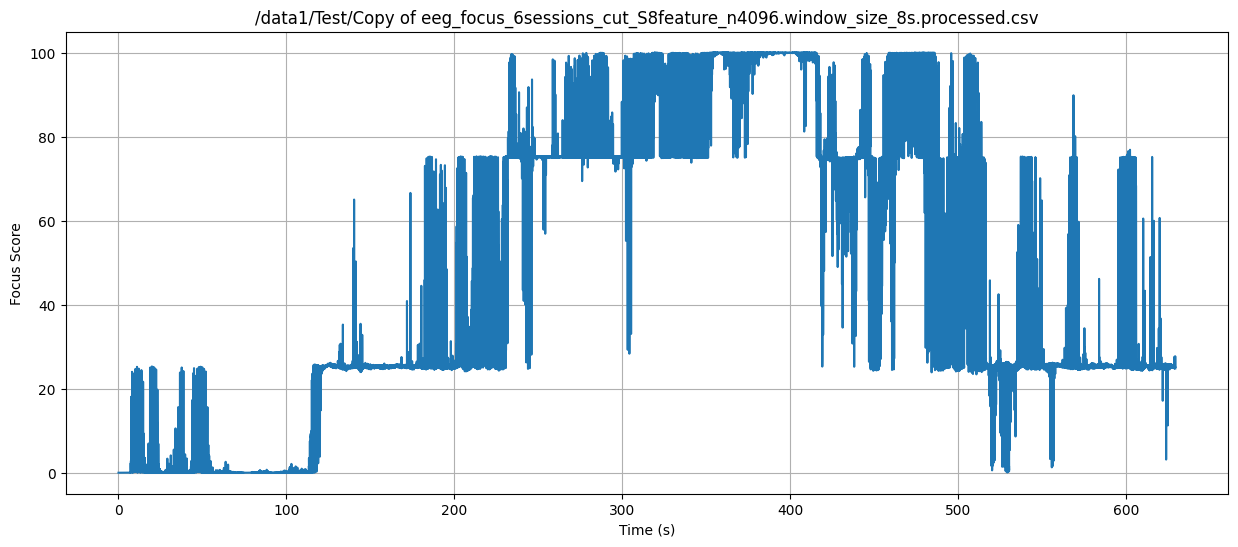

In [18]:
subjects = [1, 4, 6, 7, 8, 9, 13, 2, 3, 10]
subjects = [13, 1, 3, 8]
torch.cuda.empty_cache()
for s in subjects:
    # data_f = f'Data/Copy of eeg_focus_6sessions_cut_S{s}.b4.padding_{window_size_in_seconds}s.processed.csv'
    data_f = f'/data1/Test/Copy of eeg_focus_6sessions_cut_S{s}feature_n4096.window_size_8s.processed.csv'
    evaluate_dataset(model, data_f, image_shape=True, time_window_size=32, band_n=32, discrete_output=False, use_standard_scaler=True, device=torch.device('cuda'), batch_size=1024)